In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import os
import pandas as pd

# sys.path.append("..")
# from functions import build_vocab, encode_sequences
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
import re
from collections import Counter
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
def clean_text(text):
    text = text.lower().strip()
    text = re.sub(r'(.)\1+', r'\1\1', text)
    text = re.sub(r'[.,:]', '', text)
    text = re.sub(r'https?://\S+', '', text)
    text = re.sub(r'@\w+', '[MASK]', text)
    return text

def tokenize_text(text):
    return clean_text(text).split()

nameslist = pd.read_csv('../../data/names.csv')
nameslist = nameslist['name'].tolist()

def build_vocab(texts):
    tokenized_texts = [tokenize_text(text) for text in texts]
    all_tokens = [token for text in tokenized_texts for token in text]
    token_counts = Counter(all_tokens)
    sorted_tokens = sorted(token_counts, key=token_counts.get, reverse=True)
    
    top_tokens = sorted_tokens[:1000]
    
    bert_tokens = tokenizer.vocab.keys()
    
    top_tokens_mapped_to_bert = []
    for token in top_tokens:
        bert_token = tokenizer.tokenize(token)
        for bert_token in bert_token:
            top_tokens_mapped_to_bert.append(bert_token)
    
    top_tokens_mapped_to_bert = list(set(top_tokens_mapped_to_bert))
    print(len(top_tokens_mapped_to_bert))
    word_to_idx = {token: tokenizer.vocab[token] for token in top_tokens_mapped_to_bert}
    word_to_idx['[PAD]'] = 0
    word_to_idx['[UNK]'] = len(word_to_idx)
    word_to_idx['[MASK]'] = len(word_to_idx)
    return word_to_idx, tokenized_texts

def is_illegal_word(word):
    return any(char.isalnum() == False for char in word) or word not in word_to_idx

def encode_sequences(tokenized_texts, word_to_idx, seq_length=6):
    sequences = []
    for tokens in tokenized_texts:
        if len(tokens) < seq_length:
            continue
        for i in range(seq_length, len(tokens)):
            seq = tokens[i-seq_length:i] 
            target = tokens[i]  
            if any(is_illegal_word(word) for word in seq) or is_illegal_word(target):
                continue
            encoded_seq = [word_to_idx.get(word, word_to_idx['[UNK]']) for word in seq]
            encoded_target = word_to_idx.get(target, word_to_idx['[UNK]'])
            sequences.append((encoded_seq, encoded_target))
    return sequences

folder_path = '../../data/x'
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
csv_files = sorted(csv_files)[:40]

dfs = []
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

texts = df['text'].tolist()

print(f"Loaded {len(texts)} text samples from CSV.")

word_to_idx, tokenized_texts = build_vocab(texts)
sequences = encode_sequences(tokenized_texts, word_to_idx, seq_length=4)

print(f"Vocabulary size: {len(word_to_idx)}")
print(f"Number of sequences: {len(sequences)}")

print(word_to_idx)

/home/m/dev/scaleout/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded 398575 text samples from CSV.
958
Vocabulary size: 960
Number of sequences: 821265
{'early': 2220, 'many': 2116, 'means': 2965, 'this': 2023, '|': 1064, 'boo': 22017, 'r': 1054, 'world': 2088, 'unfortunately': 6854, 'nothing': 2498, 'sore': 14699, 'seem': 4025, 'sunny': 11559, 'taken': 2579, 'their': 2037, 'people': 2111, 'annoying': 15703, 'nice': 3835, 'mad': 5506, 'or': 2030, 'read': 3191, 'picture': 3861, 'news': 2739, 'break': 3338, 'damn': 4365, 'put': 2404, 'add': 5587, 'earlier': 3041, 'n': 1050, 'that': 2008, 'graduation': 7665, 'final': 2345, 'evening': 3944, 'at': 2012, 'account': 4070, 'friend': 2767, 'only': 2069, 'terrible': 6659, 'my': 2026, 'wish': 4299, 'scared': 6015, 'spend': 5247, 'was': 2001, 'summer': 2621, ')': 1007, 'rather': 2738, 'sigh': 6682, 'a': 1037, 'hours': 2847, 'sun': 3103, 'cu': 12731, 'seems': 3849, 'road': 2346, 'wonderful': 6919, 'figure': 3275, 'today': 2651, 'guess': 3984, 'know': 2113, 'especially': 2926, '6': 1020, 'boys': 3337, 'tickets

In [3]:
class TextDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence, target = self.sequences[idx]
        return torch.tensor(sequence), torch.tensor(target)

class NextWordLSTM(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, repetition_penalty=1.0):
        super(NextWordLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.repetition_penalty = repetition_penalty
    
    def forward(self, x):
        x = self.embedding(x)
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]  # Take the output of the last LSTM cell
        out = self.fc(lstm_out)
        
        if self.repetition_penalty != 1.0:
            for i in range(out.size(0)):
                for token in x[i]:
                    out[i, token] /= self.repetition_penalty
        
        return out


train_sequences, val_sequences = train_test_split(sequences, test_size=0.2, random_state=42)

train_dataset = TextDataset(train_sequences)
val_dataset = TextDataset(val_sequences)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [4]:
def validate_model(model, val_loader, criterion):
    model.eval()  
    total_loss = 0
    total_correct = 0
    with torch.no_grad():  
        for sequences, targets in val_loader:
            sequences, targets = sequences.to(device), targets.to(device)
            
            outputs = model(sequences)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == targets).sum().item()

    avg_loss = total_loss / len(val_loader)
    avg_acc = total_correct / len(val_loader.dataset)
    return avg_loss, avg_acc

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=3):
    train_losses = []
    val_losses = []
    val_accuracies = []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model = None

    for epoch in range(num_epochs):
        total_loss = 0
        model.train()  

        for batch_idx, (sequences, targets) in enumerate(train_loader):
            sequences, targets = sequences.to(device), targets.to(device)
            
            outputs = model(sequences)
            loss = criterion(outputs, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        val_loss, val_acc = validate_model(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}] completed, Average Train Loss: {avg_train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  
            best_model = model  
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break

    model = best_model
    return train_losses, val_losses, val_accuracies


model = NextWordLSTM(vocab_size=len(tokenizer.vocab), embed_size=128, hidden_size=256, num_layers=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

print("Starting training...")
train_losses, val_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

Starting training...
Epoch [1/10] completed, Average Train Loss: 4.3972, Validation Loss: 4.0745, Validation Accuracy: 0.2097
Epoch [2/10] completed, Average Train Loss: 3.9508, Validation Loss: 3.9276, Validation Accuracy: 0.2271
Epoch [3/10] completed, Average Train Loss: 3.8096, Validation Loss: 3.8641, Validation Accuracy: 0.2338
Epoch [4/10] completed, Average Train Loss: 3.7207, Validation Loss: 3.8330, Validation Accuracy: 0.2390
Epoch [5/10] completed, Average Train Loss: 3.6562, Validation Loss: 3.8160, Validation Accuracy: 0.2415
Epoch [6/10] completed, Average Train Loss: 3.6041, Validation Loss: 3.8117, Validation Accuracy: 0.2429
Epoch [7/10] completed, Average Train Loss: 3.5601, Validation Loss: 3.8044, Validation Accuracy: 0.2427
Epoch [8/10] completed, Average Train Loss: 3.5217, Validation Loss: 3.8071, Validation Accuracy: 0.2438
Epoch [9/10] completed, Average Train Loss: 3.4870, Validation Loss: 3.8046, Validation Accuracy: 0.2448
Epoch [10/10] completed, Average T

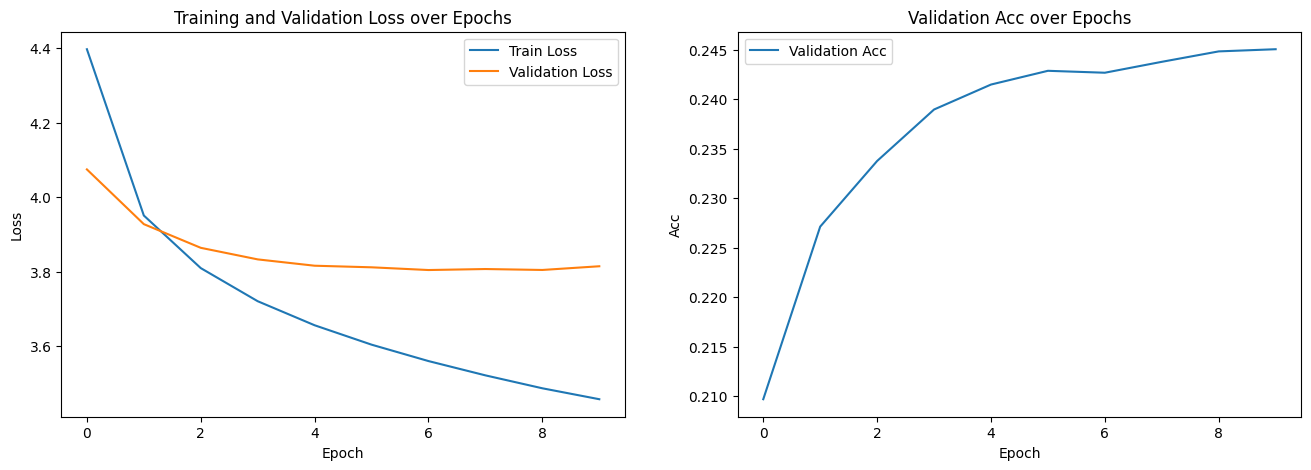

In [5]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(16, 5))

axs[0].plot(train_losses, label="Train Loss")
axs[0].plot(val_losses, label="Validation Loss")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].set_title("Training and Validation Loss over Epochs")
axs[0].legend()

axs[1].plot(val_accuracies, label="Validation Acc")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Acc")
axs[1].set_title("Validation Acc over Epochs")
axs[1].legend()

plt.show()

In [6]:
import json

# Save the vocabulary (word_to_idx dictionary)
vocab_save_path = 'vocabulary.json'
with open(vocab_save_path, 'w') as f:
    json.dump(word_to_idx, f)
print(f"Vocabulary saved to {vocab_save_path}")

#save model
model_save_path = 'model_low_vocab.pth'
torch.save(model, model_save_path)
print(f"Model saved to {model_save_path}")

Vocabulary saved to vocabulary.json
Model saved to model_low_vocab.pth


In [12]:
def predict_next_word(model, sequence, idx_to_word):
    model.eval()
    sequence = torch.tensor(sequence).unsqueeze(0).to(device) 
    with torch.no_grad():
        output = model(sequence)
        predicted_idx = torch.argmax(output, dim=1).item()
    return idx_to_word[predicted_idx]


idx_to_word = {idx: word for word, idx in word_to_idx.items()}

# List of 20 input sequences
input_sequences = [
    "what year is it",
    "how are you doing",
    "the quick brown fox",
    "once upon a time",
    "to be or not",
    "i have a dream",
    "the sun is shining",
    "all you need is",
    "life is like a",
    "in the beginning there",
    "it was the best",
    "four score and seven",
    "ask not what your",
    "we hold these truths",
    "one small step for",
    "that's one small step",
    "i came i saw",
    "to infinity and beyond",
    "may the force be",
    "elementary my dear watson"
]

print("Predicted next words:")
for sequence in input_sequences:
    indata = [word_to_idx.get(word, word_to_idx['[UNK]']) for word in sequence.split()]
    predicted_word = predict_next_word(model, indata, idx_to_word)
    print(f"'{sequence}' -> '{predicted_word}'")

Predicted next words:


KeyError: '<UNK>'